## import 

In [7]:
import os
import sys
import numpy as np
import pandas as pd
import logging
import PATH

In [9]:
import torch
from torch import nn
from torch import optim

In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm

In [4]:
import utils
from models import CNN_models
from models import log_and_save
from models import reader
from models.ScheduleOptimizer import ScheduledOptim, scheduleoptim_text
from models.popen import Auto_popen

## read model

<font color='green'> Conv_AE_mix setting4 small_channel3 
- channel_ls = [5, 128, 64, 32, 16]

- ran_epoch = 300

- best_acc = 94.25304568527918

In [14]:
def read_model(ini_file):
    popen = Auto_popen(ini_file)

    model = CNN_models.Conv_AE(*popen.model_args).cuda()
    optimizer = eval(scheduleoptim_text)
    logger = logging.getLogger("UTR")

    # resume
    utils.resume(popen,model,optimizer,logger)
    return model

In [ ]:
model = read_model("/home/wergillius/Project/UTR_VAE/log/Conv_AE_mix/setting4/small_channel3.ini")

## read data

In [15]:
from torch.utils.data import DataLoader

In [17]:
dataset = reader.UTR_dataset("A549")
dataloader = DataLoader(dataset,batch_size=50,num_workers=8)

## encode

- encode the 3970 data 
- reshape from 16,5 to 80 
- finally we have 
    - latent variable : np array of dim 80 
    - Y : np array

In [35]:
A549_iter = iter(dataloader)
embedding_ls = []
Y_ls = []

for X,Y in A549_iter:    
    # mask to 5 dimension
    zeros_side = torch.zeros((X.shape[0],X.shape[1],1))
    X_5dim = torch.cat([X,zeros_side],dim=2).float().cuda()
    
    Y_ls.append(Y.numpy())
    with torch.no_grad():
        embedding_ls.append(model.encode(X_5dim))

torch.cuda.empty_cache()

In [38]:
embedding_ls=torch.cat(embedding_ls,dim=0)  #[3970,16,5]

embedding_ls=embedding_ls.view(-1,16*5)     #[3970, 80]

In [41]:
Y_ls= np.log(np.concatenate(Y_ls))

latent_variables = embedding_ls.detach().cpu().numpy()

## dimension reduction for latent variable

In [93]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.manifold import MDS ,TSNE
from matplotlib import colors

color map

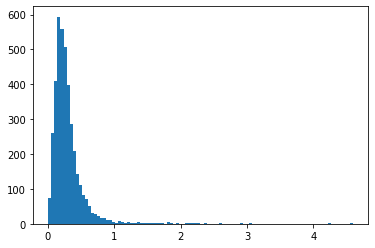

In [123]:
plt.hist(np.exp(Y_ls),bins=100);

In [97]:
high_score = Y_ls > 0
low_score = Y_ls <= -3

norm = colors.Normalize(vmin=-5,vmax=Y_ls.max())
#norm = colors.Normalize(vmin=np.log(Y_ls).min(),vmax=np.log(Y_ls).max())

scat=cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

In [76]:
latent_PCA = PCA(n_components=0.9).fit_transform(latent_variables)

In [96]:
latent_TSNE = TSNE(perplexity=100).fit_transform(latent_variables)

In [119]:
def latent_scatter_plot(latent_dim_reduc,method):
    """
    scatter plot of the dimension reduced latent variables
    """
    
    fig,(axs1,axs2,axs3) = plt.subplots(1,3,figsize=(22,6))

    for ax in (axs1,axs2,axs3):
        ax.set_xlabel("%s-1"%method)
        ax.set_ylabel("%s-2"%method)

    axs1.scatter(latent_dim_reduc[:,0],latent_dim_reduc[:,1],c=Y_ls,cmap=cm.coolwarm,norm=norm);
    axs1.set_title("Latent variables")
    axs2.scatter(latent_dim_reduc[high_score,0],latent_dim_reduc[high_score,1],c=Y_ls[high_score],cmap=cm.coolwarm,norm=norm);
    axs2.set_title("High TE Latent variables")
    axs3.scatter(latent_dim_reduc[low_score,0],latent_dim_reduc[low_score,1],c=Y_ls[low_score],cmap=cm.coolwarm,norm=norm);
    axs3.set_title("Low TE Latent variables")

    cb_ax = fig.add_axes([0.95,0.15,0.01,0.7])
    plt.colorbar(scat,cax=cb_ax)

    return fig

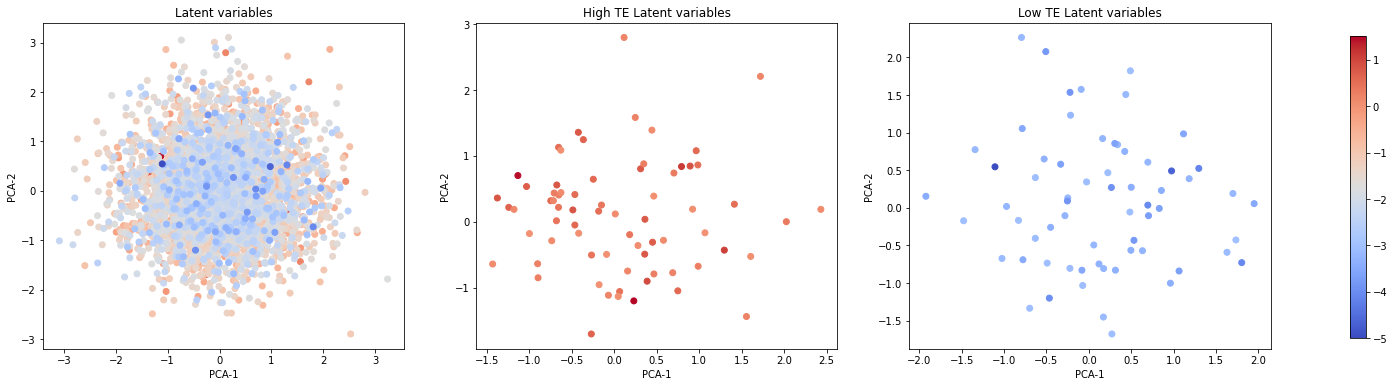

In [120]:
PCA_fig = latent_scatter_plot(latent_PCA,"PCA")

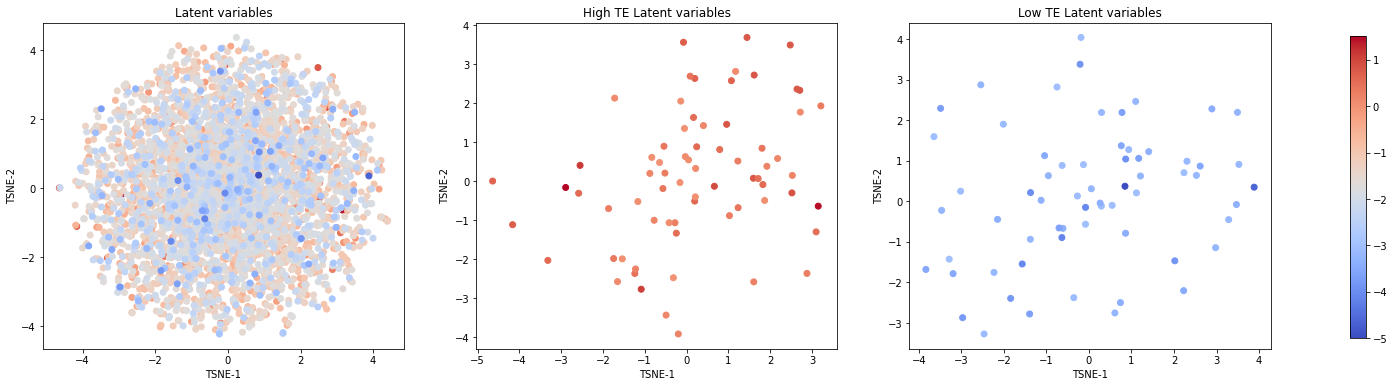

In [118]:
TSNE_fig = latent_scatter_plot(latent_TSNE)

## Regression

In [124]:
from sklearn.tree import DecisionTreeRegressor
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split 

In [152]:
training,testing = train_test_split(range(3970),test_size=0.2)

In [164]:
Tree = DecisionTreeRegressor(criterion='mse')
Tree.fit(latent_variables[training,:],Y_ls[training])

DecisionTreeRegressor()

In [158]:
from sklearn.linear_model import LinearRegression

In [159]:
regressor = LinearRegression().fit(latent_variables[training,:],Y_ls[training])

Text(0.5, 1.0, 'Linear Regressor\n')

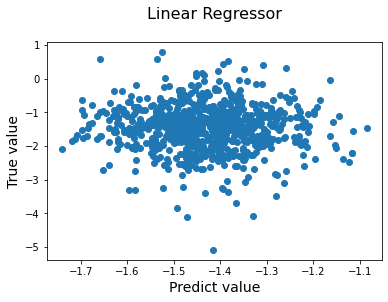

In [212]:
plt.scatter(regressor.predict(latent_variables[testing]),Y_ls[testing]);
plt.xlabel('Predict value',fontsize=14)
plt.ylabel('True value',fontsize=14)
plt.title('Linear Regressor\n',fontsize=16)

## maximum distance dimension

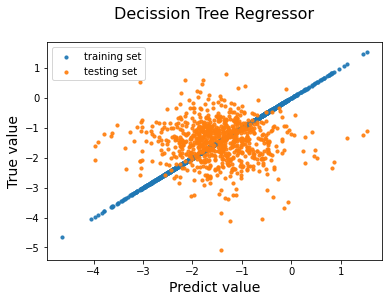

In [226]:
plt.scatter(Tree.predict(latent_variables[training]),Y_ls[training],s=10,label='training set',alpha=0.9);
plt.scatter(Tree.predict(latent_variables[testing]),Y_ls[testing],s=10,label='testing set',alpha=0.9);
plt.xlabel('Predict value',fontsize=14)
plt.ylabel('True value',fontsize=14)
plt.title('Decission Tree Regressor\n',fontsize=16)
plt.legend()

Text(0.5, 1.0, 'Decission Tree Regressor on testing set\n')

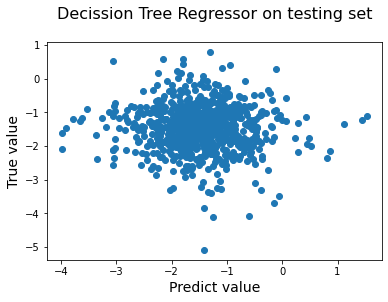

In [217]:
plt.scatter(Tree.predict(latent_variables[testing]),Y_ls[testing]);
plt.xlabel('Predict value',fontsize=14)
plt.ylabel('True value',fontsize=14)
plt.title('Decission Tree Regressor on testing set\n',fontsize=16)

In [166]:
high_l_variables = np.mean(latent_variables[high_score],axis=0)
low_l_variables = np.mean(latent_variables[low_score],axis=0)

In [178]:
differences = (high_l_variables - low_l_variables)**2

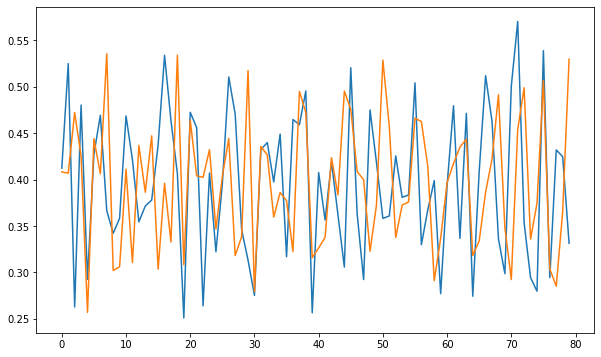

In [197]:
plt.figure(figsize=(10,6))
plt.plot(high_l_variables);
plt.plot(low_l_variables);

In [180]:
distance = differences.reshape(-1,1) + differences.reshape(-1,1).T

In [181]:
distance.shape

(80, 80)

In [187]:
np.mean(differences)

0.008939842

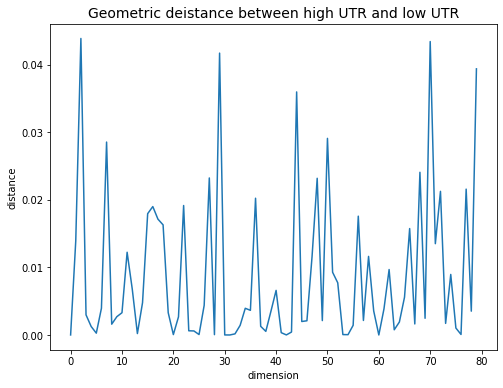

In [201]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.set_title('Geometric deistance between high UTR and low UTR',fontsize=14)
ax.set_xlabel('dimension')
ax.set_ylabel("distance")
ax.plot(differences)

In [202]:
np.where(differences > 0.04)

(array([ 2, 29, 70]),)

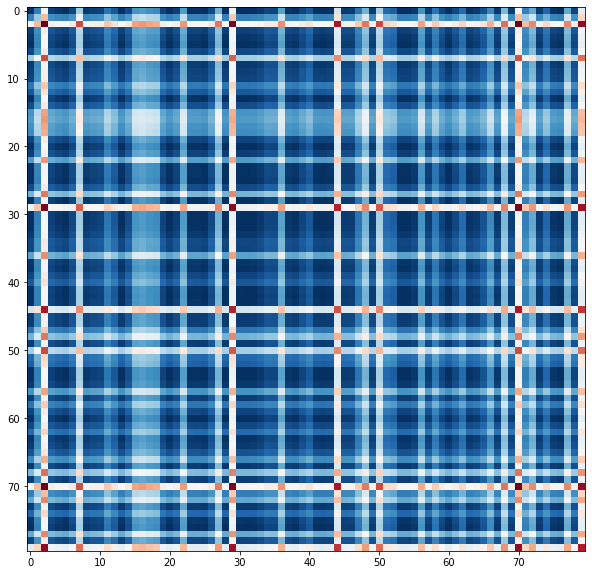

In [185]:
plt.figure(figsize=(10,10))
plt.imshow(distance,aspect='auto',cmap=cm.RdBu_r);

In [229]:
com4_dim = latent_variables[:,[2,29,70,79]]

In [231]:
com4_dim_pca = PCA(n_components=2).fit_transform(com4_dim)

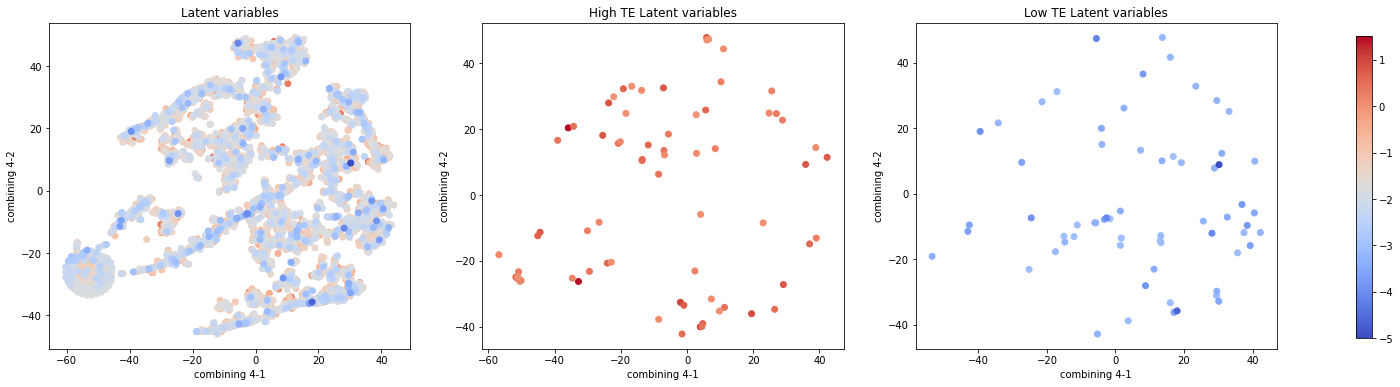

In [242]:
com4_dim_tsne = TSNE(perplexity=60,n_iter=3000,n_iter_without_progress=100,).fit_transform(com4_dim)

com4tsne_fig = latent_scatter_plot(com4_dim_tsne, method='combining 4')

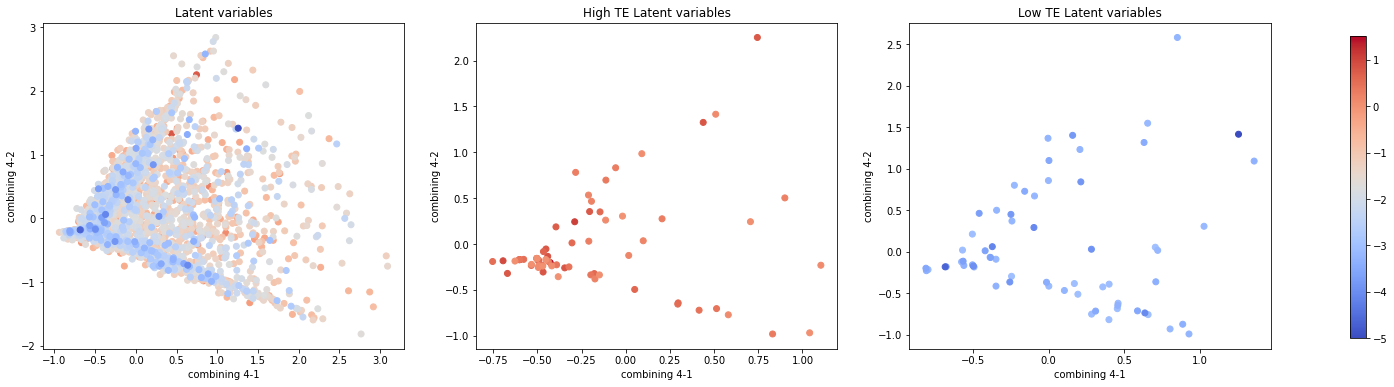

In [235]:
com4pca_fig = latent_scatter_plot(com4_dim_pca, method='combining 4')

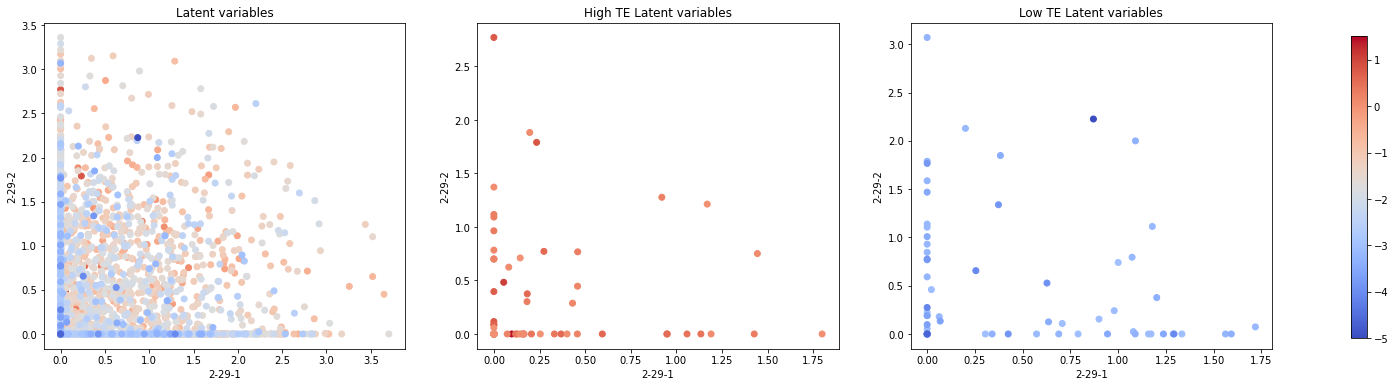

In [191]:
com2_29_fig = latent_scatter_plot(latent_variables[:,[2,29]],method="2-29")

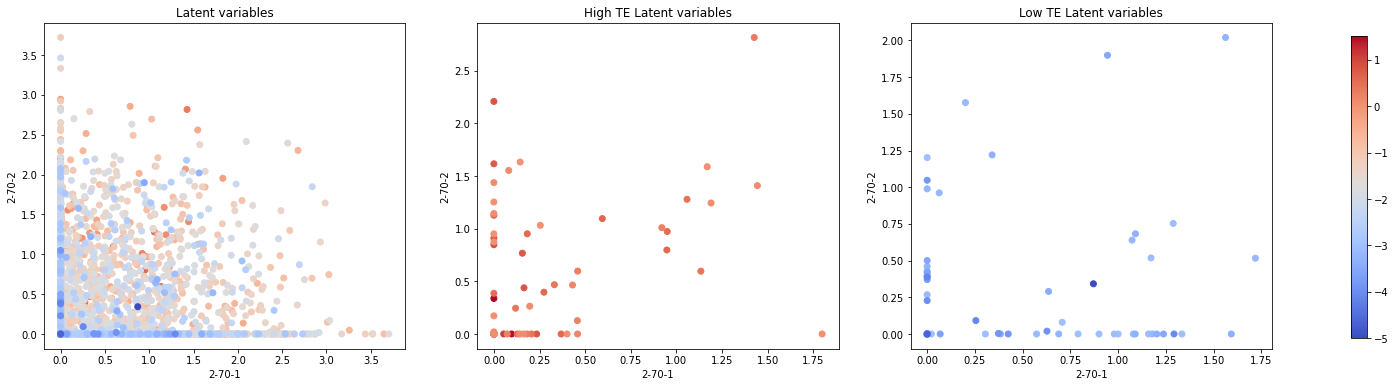

In [203]:
com2_29_fig = latent_scatter_plot(latent_variables[:,[2,70]],method="2-70")

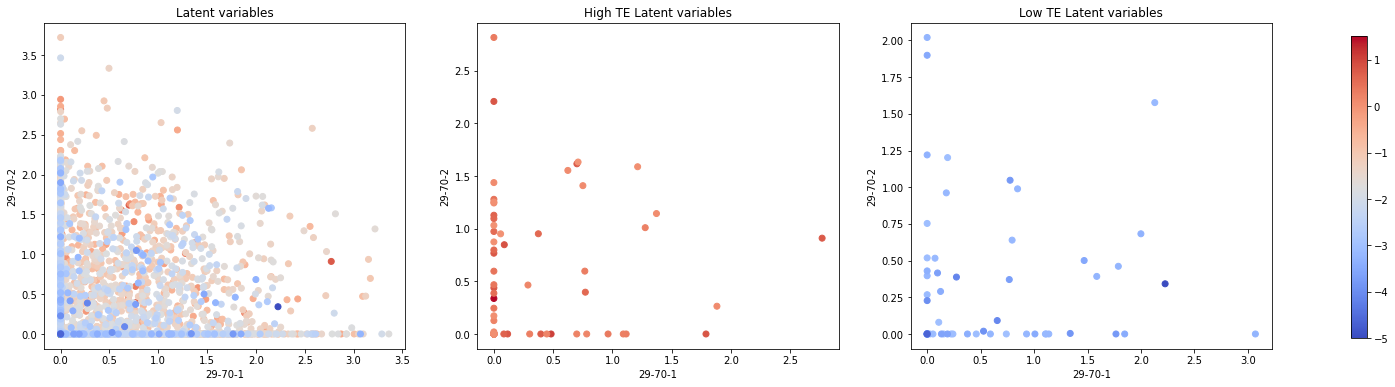

In [194]:
com2_29_fig = latent_scatter_plot(latent_variables[:,[29,70]],method="29-70")